In [1]:
import pandas as pd
import numpy as np
from lxml import objectify
import xml.etree.ElementTree as ET
import requests
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import style
import os
import re
import pycats
import warnings
warnings.filterwarnings("ignore")

/Users/vedantwalia/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
tree = ET.parse('Library.xml')
root = tree.getroot()
root

<Element 'plist' at 0x14eea46d0>

In [3]:
main_dict=root.findall('dict')

for index, item in enumerate(list(main_dict[0])):  
    print('index #{} = <{}>'.format(index, item.tag))
    if item.tag=="dict":
        print('The tracks dict has been found!')
        tracks_dict=item
        break


index #0 = <key>
index #1 = <integer>
index #2 = <key>
index #3 = <integer>
index #4 = <key>
index #5 = <date>
index #6 = <key>
index #7 = <string>
index #8 = <key>
index #9 = <integer>
index #10 = <key>
index #11 = <true>
index #12 = <key>
index #13 = <string>
index #14 = <key>
index #15 = <string>
index #16 = <key>
index #17 = <dict>
The tracks dict has been found!


In [4]:
tracklist = list(tracks_dict.findall('dict'))
len(tracklist)

6487

In [5]:
kinds = set([])
for i in range(len(tracklist)):
    for j in range(len(tracklist[i])):
        if (tracklist[i][j].tag == 'key' and tracklist[i][j].text== 'Kind'):
            kinds.add(tracklist[i][j+1].text)

kinds = pd.Series(list(kinds))
kinds

0             MPEG-4 video file
1      Purchased AAC audio file
2                AAC audio file
3    Apple Music AAC audio file
4               MPEG audio file
dtype: object

In [6]:
valid_datatypes = pd.Series([
    'AAC audio file',
    'MPEG audio file',
    'MPEG audio file',
    'Apple Music AAC audio file'
])

In [7]:
# This code will retrieve all the 'keys' (attributes) of the first track of the corresponding Kind
def cols(kind):
    cols = []
    kind_found = False
    for i in range(len(tracklist)):
        for j in range(len(tracklist[i])):
            if tracklist[i][j].tag == "key":
                cols.append(tracklist[i][j].text)
            if (j < len(tracklist[i]) - 1 and tracklist[i][j].text == "Kind" and tracklist[i][j + 1].text == kind):
                kind_found = True
                break  # Once the kind is found, break the inner loop
        if kind_found:
            return set(cols)  # Return the set of columns if kind is found

# Sample usage
cols('AAC audio file')


{'Album',
 'Album Artist',
 'Album Loved',
 'Apple Music',
 'Artist',
 'Artwork Count',
 'Bit Rate',
 'Clean',
 'Compilation',
 'Composer',
 'Date Added',
 'Date Modified',
 'Disc Count',
 'Disc Number',
 'Explicit',
 'Favorited',
 'Genre',
 'Kind',
 'Loved',
 'Name',
 'Normalization',
 'Part Of Gapless Album',
 'Persistent ID',
 'Play Count',
 'Play Date',
 'Play Date UTC',
 'Playlist Only',
 'Purchased',
 'Release Date',
 'Sample Rate',
 'Size',
 'Skip Count',
 'Skip Date',
 'Sort Album',
 'Sort Album Artist',
 'Sort Artist',
 'Sort Composer',
 'Sort Name',
 'Total Time',
 'Track Count',
 'Track ID',
 'Track Number',
 'Track Type',
 'Year'}

In [8]:
results = map(cols, valid_datatypes)
results_list = [list(item) for item in results]
results_list

[['Sample Rate',
  'Favorited',
  'Artwork Count',
  'Sort Artist',
  'Play Date UTC',
  'Artist',
  'Total Time',
  'Size',
  'Year',
  'Track Count',
  'Sort Name',
  'Date Added',
  'Album Artist',
  'Album',
  'Loved',
  'Disc Number',
  'Explicit',
  'Sort Composer',
  'Date Modified',
  'Play Date',
  'Track Type',
  'Purchased',
  'Playlist Only',
  'Album Loved',
  'Track Number',
  'Persistent ID',
  'Apple Music',
  'Sort Album Artist',
  'Compilation',
  'Skip Date',
  'Clean',
  'Release Date',
  'Genre',
  'Sort Album',
  'Normalization',
  'Part Of Gapless Album',
  'Bit Rate',
  'Skip Count',
  'Track ID',
  'Name',
  'Kind',
  'Play Count',
  'Disc Count',
  'Composer'],
 ['Sample Rate',
  'Favorited',
  'Matched',
  'Artwork Count',
  'Sort Artist',
  'Play Date UTC',
  'Artist',
  'Total Time',
  'Size',
  'Year',
  'Track Count',
  'Sort Name',
  'Date Added',
  'Album Artist',
  'Album',
  'Loved',
  'Disc Number',
  'Explicit',
  'Sort Composer',
  'Date Modified',

In [9]:
flat_list=[]

for item in results_list:
  for sub_item in item:
    flat_list.append(sub_item)

unique_cols = set(flat_list) # set funcation gives unique items list

print(unique_cols)



{'Sample Rate', 'Favorited', 'Matched', 'Artwork Count', 'Sort Artist', 'Play Date UTC', 'Artist', 'Total Time', 'Size', 'Year', 'Track Count', 'Sort Name', 'Date Added', 'Album Artist', 'Album', 'Loved', 'Disc Number', 'Explicit', 'Sort Composer', 'Date Modified', 'Play Date', 'Track Type', 'Purchased', 'Playlist Only', 'Album Loved', 'Track Number', 'Persistent ID', 'Apple Music', 'Sort Album Artist', 'Compilation', 'Skip Date', 'Clean', 'Release Date', 'Genre', 'Sort Album', 'Normalization', 'Disliked', 'Part Of Gapless Album', 'Bit Rate', 'Skip Count', 'Track ID', 'Name', 'Kind', 'Play Count', 'Disc Count', 'Grouping', 'Composer'}


In [10]:
len(unique_cols) # superset of all common unique entries between all the filetypes

47

In [11]:
unique_cols_list = list(unique_cols)

df_tracks=pd.DataFrame(columns=unique_cols_list)

dict1={}

for song_i in range(len(tracklist)):
  for attribute_i in range(len(tracklist[song_i])):
    if tracklist[song_i][attribute_i].tag=="key":
      dict1[tracklist[song_i][attribute_i].text]=tracklist[song_i][attribute_i+1].text
  list_values=[i for i in dict1.values()]
  list_keys=[j for j in dict1.keys()]
  if dict1['Kind'] in valid_datatypes.unique():
    df_temp=pd.DataFrame([list_values],columns=list_keys)
    df_tracks=pd.concat([df_tracks,df_temp],axis=0,ignore_index=True,sort=True)

In [12]:
df_tracks[['Play Count']] = df_tracks[['Play Count']].apply(pd.to_numeric)

In [13]:
top_songs=(df_tracks.sort_values(by='Play Count', ascending=False)[['Name', 'Artist', 'Play Count', 'Genre']])

top_songs

,Name,Artist,Play Count,Genre
4555,Save Your Tears (Remix),The Weeknd & Ariana Grande,112.0,R&B/Soul
4857,Self Love (Spider-Man: Across the Spider-Verse),Metro Boomin & Coi Leray,98.0,Hip-Hop/Rap
4510,"Wish On An Eyelash, Pt. 2",Mallrat & The Chainsmokers,83.0,Alternative
4476,Eyes Wide Shut,"ILLENIUM, Avril Lavigne & Travis Barker",78.0,Dance
4813,Electric Touch (Taylor's Ve rsion) (From The V...,Taylor Swift,70.0,Pop
...,...,...,...,...
126,The Stranger,Ingrid Andress,NaN,Country
127,Chemical,Post Malone,NaN,Pop
128,Too Far Gone?,Metallica,NaN,Metal
129,Gangsta's Paradise (feat. L.V.),Coolio,NaN,Hip-Hop/Rap


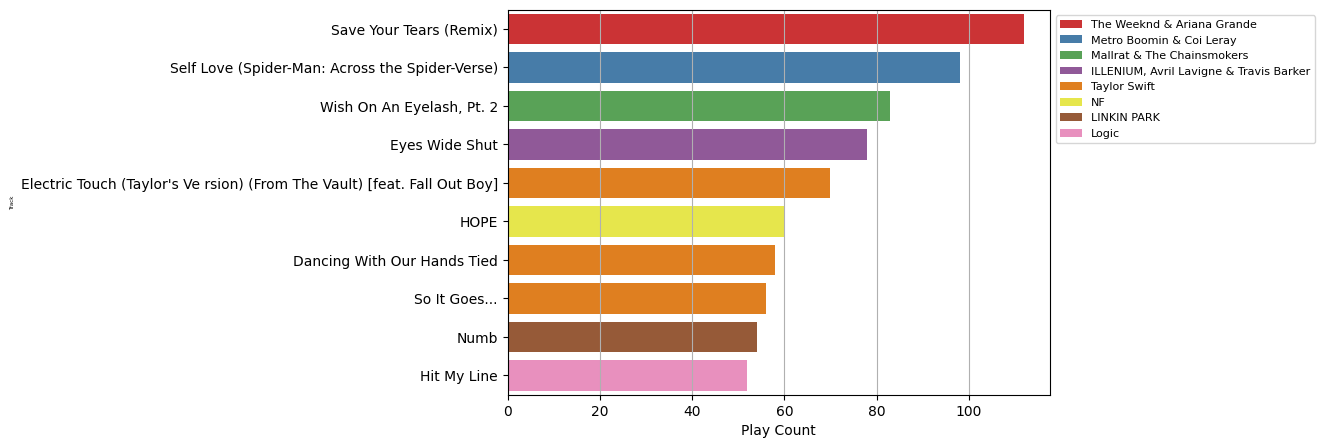

In [14]:
plt.clf()
ax=sns.barplot(x='Play Count',
            y='Name',
            hue='Artist',
            data=top_songs.head(10),
            dodge=False,
            palette=sns.color_palette("Set1"))
ax.figure.set_size_inches(7,5)
ax.legend(fontsize=8, loc='upper left', bbox_to_anchor=(1, 1))
ax.xaxis.grid(True)
ax.set_ylabel('Track', fontsize=4)
#plt.savefig('test.png', dpi=400)
plt.show()

In [15]:
ntracks_album=df_tracks.groupby('Album').size()
full_albums=(ntracks_album[ntracks_album>5]
             .reset_index()
             .rename(columns={0: "n_tracks"}))
full_albums

,Album,n_tracks
0,#3,9
1,(What's the Story) Morning Glory? [Deluxe Edit...,9
2,1989 (Taylor's Version),21
3,=,14
4,A Head Full Of Dreams,9
...,...,...
146,misery lake - EP,6
147,no future,19
148,reputation,7
149,vertigo,13


In [16]:
plays_by_album=(df_tracks
                .groupby('Album')['Play Count']
                .sum()
                .reset_index()
                .sort_values(by='Play Count', ascending=False))

full_albums_ranked=plays_by_album[plays_by_album.Album.isin(full_albums.Album)]
full_albums_ranked.head(10)

,Album,Play Count
1550,ILLENIUM,311.0
1923,METRO BOOMIN PRESENTS SPIDER-MAN: ACROSS THE S...,294.0
3806,reputation,277.0
1050,Fallen Embers (Deluxe Version),204.0
2788,Speak Now (Taylor's Version),188.0
505,Blurryface,155.0
2591,Savages,151.0
3788,mainstream sellout (life in pink deluxe),132.0
2609,Scaled And Icy (Livestream Version),130.0
1525,I met you when I was 18. (the playlist),124.0


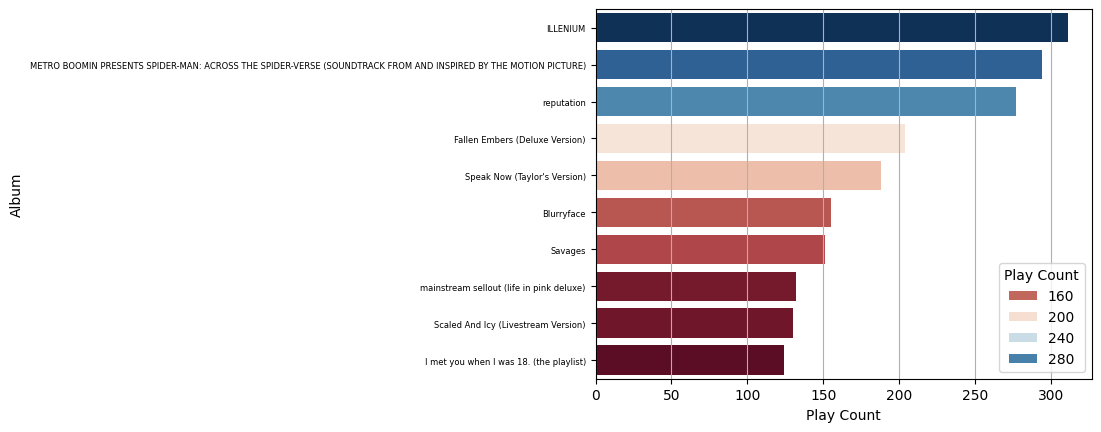

In [17]:
plt.clf()
ax=sns.barplot(x='Play Count',
               y='Album',
               hue='Play Count',
              data=full_albums_ranked.head(10),
              dodge='auto',
              palette='RdBu')
ax.tick_params(axis='y', labelsize=6)
ax.xaxis.grid(True)
plt.show()

In [18]:
delimiters=' & ',', ',' Feat. ',' feat. ','/', ' feat ', 'Feat'
regexPattern = '|'.join(map(re.escape, delimiters))
reg_split=re.compile(regexPattern)
artists_splitted=df_tracks.Artist.str.split(regexPattern)
artists_splitted

0                                [Nirvana]
1                          [Fleetwood Mac]
2                            [Michigander]
3                          [You Me At Six]
4                           [Zara Larsson]
                       ...                
6462    [Future, Metro Boomin, The Weeknd]
6463                         [Soundgarden]
6464                           [Soft Cell]
6465                           [Pete Yorn]
6466                            [Flo Rida]
Name: Artist, Length: 6467, dtype: object

In [19]:
songs=[]
for i, song in df_tracks.Name.items():
  ## Parse the artists of the song
  if df_tracks.Artist.values[i]=='Now, Now':
    artist_to_assign=[df_tracks.Artist.values[i]]
  if df_tracks.Artist.values[i]=='AC/DC':
    artist_to_assign=[df_tracks.Artist.values[i]]
  else:
    artist_to_assign=artists_splitted.values[i]

  ## add elements to the list of songs
  songs.append({'Name': song,
                'Number': i,
                'Artists': artist_to_assign})

songs[:5]

[{'Name': 'About a Girl (Live Acoustic)', 'Number': 0, 'Artists': ['Nirvana']},
 {'Name': 'Go Your Own Way', 'Number': 1, 'Artists': ['Fleetwood Mac']},
 {'Name': 'Cannonball', 'Number': 2, 'Artists': ['Michigander']},
 {'Name': 'SUCKAPUNCH', 'Number': 3, 'Artists': ['You Me At Six']},
 {'Name': "Can't Tame Her", 'Number': 4, 'Artists': ['Zara Larsson']}]

In [20]:
# One regex for each pattern variation: round brackets, squared brackets, and no brackets
# Note how in the variations with brackets we have to look for the closing bracket, while in the "bare" variation we just extract everthying from "feat." to the end of the string
re_circ_brackets=re.compile(' \(feat\.* (.*)\)')
re_sq_brackets=re.compile(' \[feat. ([^\[]*)\]')
re_bare=re.compile(' feat. (.*)$')

# Creating bolean arrays based on which of the pattern variations is present in the song name (note that it could be none)
feat_curved_brackets=df_tracks.Name.str.contains('\(feat.').values
feat_squared_brackets=df_tracks.Name.str.contains('\[feat.').values
feat_bare=df_tracks.Name.str.contains(' feat.').values

In [21]:
df_tracks_clean = df_tracks.dropna(subset=['Play Count'])

df_tracks_clean['Play Count'].dtype

dtype('float64')

In [22]:
import re

for i, song in df_tracks_clean['Name'].items():
    artists_feat = ''  # Initialize artists_feat variable
    if feat_curved_brackets[i]:
        artists_feat = re.search(r'\((.*?)\)', song).group(1)
    elif feat_squared_brackets[i]:
        artists_feat = re.search(r'\[(.*?)\]', song).group(1)
    elif feat_bare[i]:
        try:
            artists_feat = re.search(r'\{(.*?)\}', song).group(1)
        except AttributeError:
            pass  # Handle the case when no match is found

    if artists_feat:  # Check if artists_feat is not an empty string
        splitted_artists_feat = re.split(r',\s*', artists_feat)
        songs[i]['Artists'].extend(splitted_artists_feat)

In [23]:
for i in range(len(songs)):
  for j in range(len(songs[i]['Artists'])):
    artist_name=songs[i]['Artists'][j]
    norm_artist_name=artist_name.title().replace('.', '')
    songs[i]['Artists'][j]=norm_artist_name


In [24]:
for i in range(len(songs)):
  for j in range(len(songs[i]['Artists'])):
    artist_name=songs[i]['Artists'][j]
    norm_artist_name=artist_name.title().replace('.', '')
    songs[i]['Artists'][j]=norm_artist_name


In [25]:
for i in range(len(songs)):
  for j in range(len(songs[i]['Artists'])):
    artist_name=songs[i]['Artists'][j]
    norm_artist_name=artist_name.title().replace('.', '')
    songs[i]['Artists'][j]=norm_artist_name


In [26]:
artists={}

for i in range(len(songs)):
  for j in range(len(songs[i]['Artists'])):
    if songs[i]['Artists'][j] not in artists:
      artists[songs[i]['Artists'][j]]=df_tracks['Play Count'][i]
    else:
      artists[songs[i]['Artists'][j]]+=df_tracks['Play Count'][i]

df_artists_plays=pd.DataFrame(artists.items(),
                              columns=['Artist', 'Play Count'])

df_artists_plays.head(5)

,Artist,Play Count
0,Nirvana,NaN
1,Fleetwood Mac,NaN
2,Michigander,NaN
3,You Me At Six,NaN
4,Zara Larsson,NaN


In [27]:
df_artists_plot=(df_artists_plays
                 .sort_values(by='Play Count', ascending=False)
                 .head(10))

df_artists_plot

,Artist,Play Count
447,Taylor Swift,1093.0
131,Illenium,909.0
133,Twenty One Pilots,645.0
170,Linkin Park,637.0
161,Logic,364.0
148,Eminem,356.0
178,The Weeknd,352.0
219,Mgk,351.0
467,Onerepublic,349.0
125,Lauv,345.0


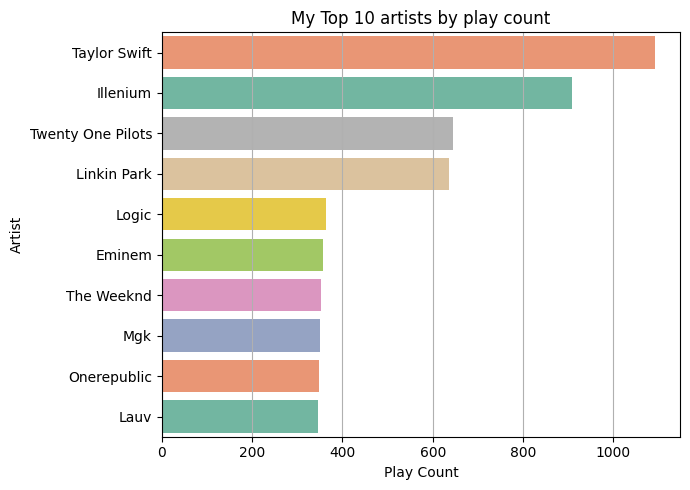

In [28]:
plt.clf()
ax=sns.barplot(x='Play Count',
               y='Artist',
               hue='Play Count',
              data=df_artists_plot,
              dodge=False,
              palette='Set2')

# Rotating labels trying to make them fit
ax.figure.set_size_inches(7,5)
ax.xaxis.grid(True)
plt.title('My Top 10 artists by play count')
plt.tight_layout()
plt.legend([],[], frameon=False)
plt.show()

In [29]:
df_tracks[['Year']]=df_tracks[['Year']].apply(pd.to_numeric)

df_tracks=(df_tracks
.assign(FiveYearPeriod=pd.to_numeric(np.floor(df_tracks.Year / 5) * 5, downcast='integer')))

In [30]:
df_tracks.groupby("FiveYearPeriod").size()


FiveYearPeriod
1900       1
1945       1
1950       4
1955       4
1960       5
1965      59
1970     104
1975     126
1980     145
1985     120
1990     133
1995     158
2000     426
2005     531
2010    1185
2015    1459
2020    2006
dtype: int64

In [31]:
catg_years=pd.Categorical(df_tracks.FiveYearPeriod,
               ordered=True,
               categories=['Before 1995', 1995, 2000, 2005, 2010, 2015, 2020])

df_tracks.FiveYearPeriod=catg_years.rename_categories({1995: '1995-1999', 2000: '2000-2004', 2005: '2005-2009', 2010: '2010-2014', 2015: '2015-2019', 2020: '2020-Present'})

In [32]:
songs_period=df_tracks.groupby(['FiveYearPeriod']).size()
songs_period

FiveYearPeriod
Before 1995        0
1995-1999        158
2000-2004        426
2005-2009        531
2010-2014       1185
2015-2019       1459
2020-Present    2006
dtype: int64

In [37]:
plays_period=df_tracks.groupby(['FiveYearPeriod'])['Play Count'].mean()
plays_period.show()

AttributeError: 'Series' object has no attribute 'show'

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


<Figure size 640x480 with 0 Axes>

posx and posy should be finite values
posx and posy should be finite values


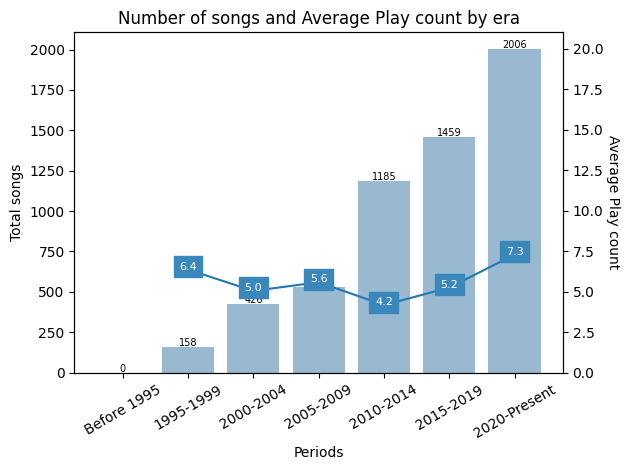

In [36]:


plt.clf()
fig, ax1 = plt.subplots()
sns1=sns.barplot(x=songs_period.index, y=songs_period.values, alpha=0.5)

# Adding labels to bar plot
for a, b in zip(songs_period.index, songs_period.values):
  plt.text(x = a, y = b+5, s = '{:.0f}'.format(b), size=7, color='black', ha='center')


ax2 = ax1.twinx()
sns2=sns.lineplot(x=plays_period.index, y=plays_period.values, marker='o')
sns2.set_ylim(0, 21)

sns1.set(xlabel='Periods', ylabel='Total songs')
sns2.set_ylabel('Average Play count', rotation=270, labelpad=12.0)
sns1.set_xticklabels(sns1.get_xticklabels(),rotation = 30)

# Adding labels to line plot
for x, y in zip(plays_period.index, plays_period.values):
  plt.text(x = x, y = y, s = '{:.1f}'.format(y), size=8, color='white', ha='center').set_backgroundcolor('#3A87BC')

sns1.set(title='Number of songs and Average Play count by era')
plt.tight_layout()
plt.savefig('fig_twop_plots.png')
plt.show()

In [ ]:

plt.clf()
fig, ax1 = plt.subplots()
sns1=sns.barplot(x=songs_period.index, y=songs_period.values, alpha=0.5)

# Adding labels to bar plot
for a, b in zip(songs_period.index, songs_period.values):
  plt.text(x = a, y = b+5, s = '{:.0f}'.format(b), size=7, color='black', ha='center')


ax2 = ax1.twinx()
sns2=sns.lineplot(x=plays_period.index, y=plays_period.values, marker='o')
sns2.set_ylim(0, 21)

sns1.set(xlabel='Periods', ylabel='Total songs')
sns2.set_ylabel('Average Play count', rotation=270, labelpad=12.0)
sns1.set_xticklabels(sns1.get_xticklabels(),rotation = 30)

# Adding labels to line plot
for x, y in zip(plays_period.index, plays_period.values):
  plt.text(x = x, y = y, s = '{:.1f}'.format(y), size=8, color='white', ha='center').set_backgroundcolor('#3A87BC')

sns1.set(title='Number of songs and Average Play count by era')
plt.tight_layout()
plt.savefig('fig_twop_plots.png')
plt.show()

In [34]:
df_tracks['Genres_lumped']=pycats.cat_lump(pycats.as_cat(df_tracks['Genre']), 4)
df_tracks['Genres_lumped'].value_counts()

Genres_lumped
Other          1905
Pop            1829
Alternative    1437
Rock            956
Dance           340
Name: count, dtype: int64

ValueError: The palette dictionary is missing keys: {'Dance'}

<Figure size 640x480 with 0 Axes>

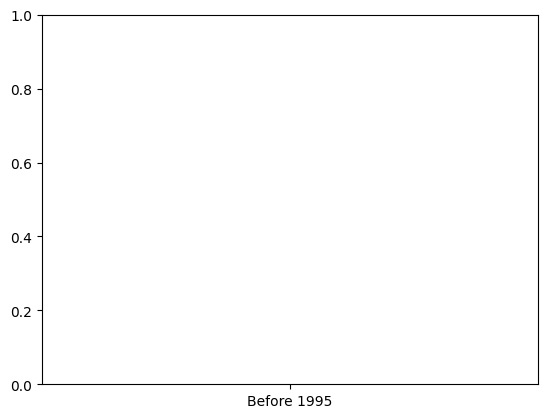

In [35]:
colors = {'Other': "grey", 'Pop': "#4878CF", 'Alternative': "#ffb300", 'Rock':"#D65F5F", 'Urbano latino': "#B47CC7"}

plt.clf()
plt.figure()

# Draw a categorical scatterplot to show each observation
ax = sns.stripplot(data=df_tracks, y="Play Count", x="FiveYearPeriod", hue="Genres_lumped", size=5, alpha=0.7, jitter=0.25, palette=colors)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 30)
ax.legend(title='Genres')
plt.title('Play count of my songs, by era and genre')
plt.tight_layout()
plt.show()